In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
#Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2, 2)   # 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2, 2),  # 128 x 7 x 7
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(x.size(0), -1)
        return out



#Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16, 1, 3, padding=1),
            nn.Sigmoid()   # [0,1] 범위
        )

    def forward(self, x):
        out = x.view(x.size(0), 256, 7, 7)  # encoder에서 flatten된 걸 복원
        out = self.layer1(out)
        out = self.layer2(out)
        return out


#Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

In [3]:

#데이터(MNIST)
mnist_train = dset.MNIST("./data/MNIST", train=True,
                         transform=transforms.ToTensor(),
                         download=True)
mnist_test = dset.MNIST("./data/MNIST", train=False,
                        transform=transforms.ToTensor(),
                        download=True)

batch_size = 100
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.16MB/s]


In [4]:
#준비
num_epoch = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

#루프
for epoch in range(num_epoch):
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.to(device)

        optimizer.zero_grad()
        output = autoencoder(image)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epoch, loss.item()))

Epoch [1/10], Loss: 0.0032
Epoch [2/10], Loss: 0.0018
Epoch [3/10], Loss: 0.0016
Epoch [4/10], Loss: 0.0010
Epoch [5/10], Loss: 0.0010
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0008
Epoch [8/10], Loss: 0.0006
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0005


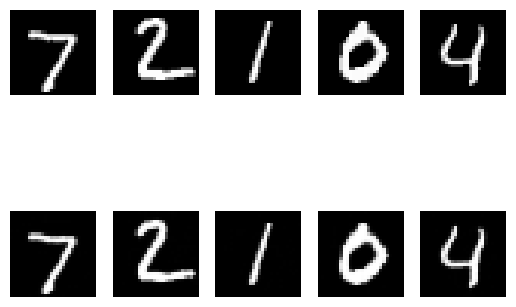

In [5]:
#테스트결과
autoencoder.eval()
with torch.no_grad():
    for image, _ in test_loader:
        image = image.to(device)
        output = autoencoder(image)
        break
#CPU변환
image = image.cpu()
output = output.cpu().detach()


#시각화
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(image[i][0], cmap='gray')
    plt.axis("off")

    plt.subplot(2, 5, i+6)
    plt.imshow(output[i][0], cmap='gray')
    plt.axis("off")

plt.show()